In [38]:
import numpy as np
from aquapointer.analog.utils import detuning_scale_utils as dsu
from aquapointer.slicing import density_file_to_grid, density_slices_by_axis, find_density_origin, find_density_point_boundaries

import matplotlib.pyplot as plt

In [39]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [40]:
print(find_density_origin(grid))
print(find_density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[40. 40. 40.]


In [41]:
points, densities = density_slices_by_axis(grid, axis=np.array([0, 0, 1]), distances=np.array([10, 20, 30]))

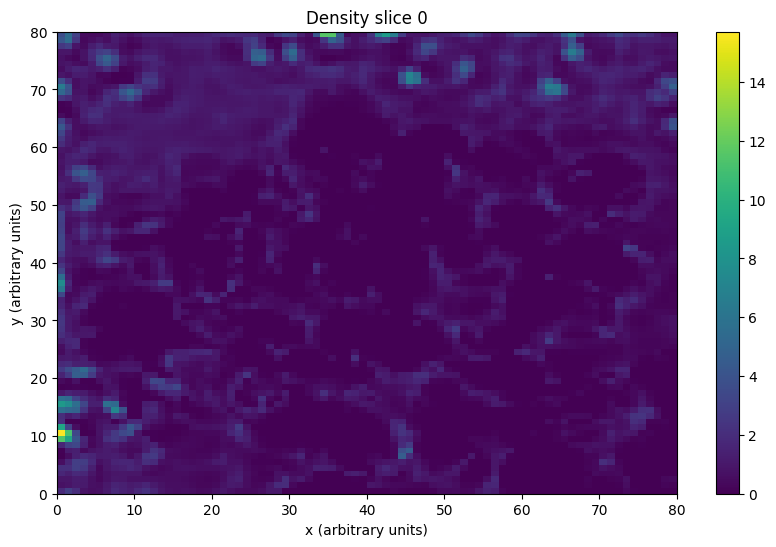

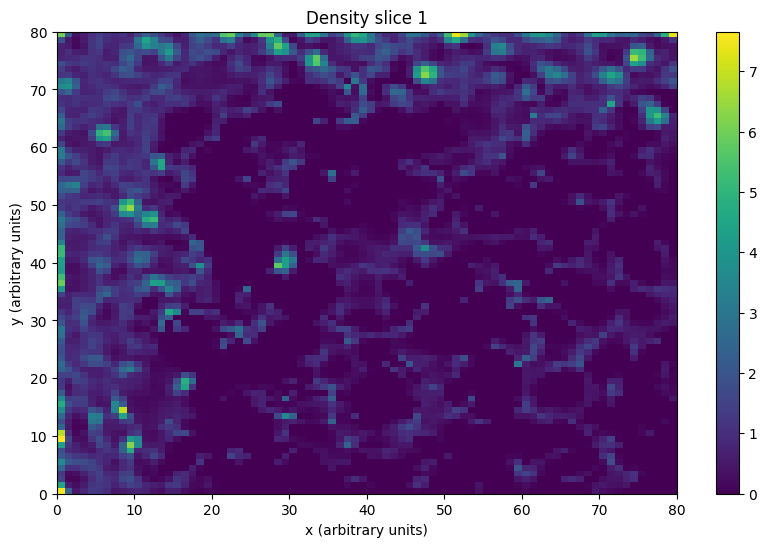

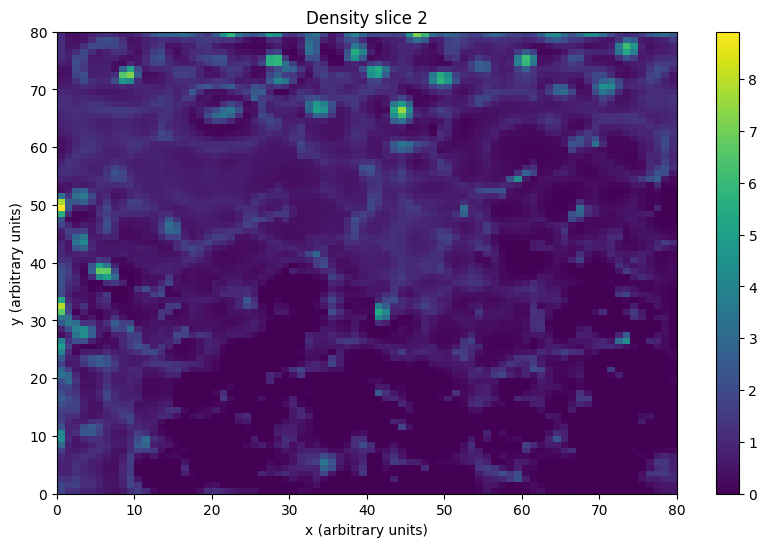

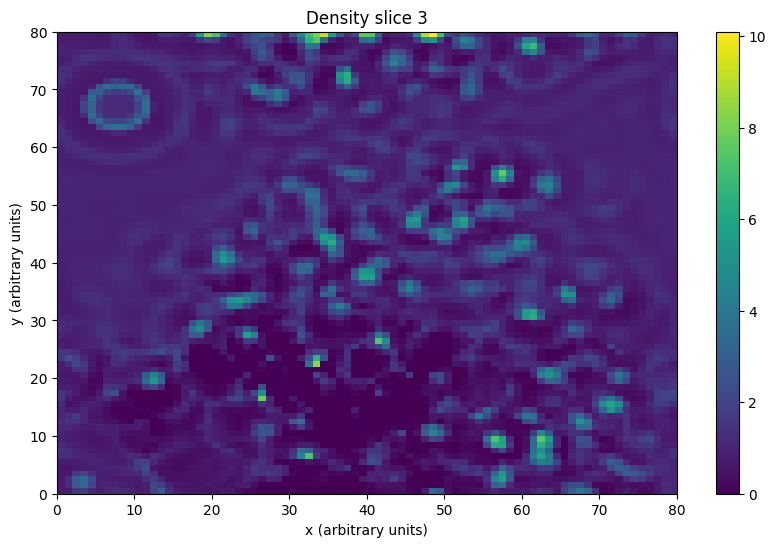

In [42]:
for k, density in enumerate(densities):
    fig, ax = dsu.plot_density(
            density, title=f"Density slice {k}"
        )
plt.show()

In [43]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [44]:
print(find_density_origin(grid_bd))
print(find_density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[40. 40. 40.]


In [45]:
points_bd, densities_bd = density_slices_by_axis(grid, axis=np.array([0, 1, 0]), distances=np.linspace(5, 35, 7, dtype=int))

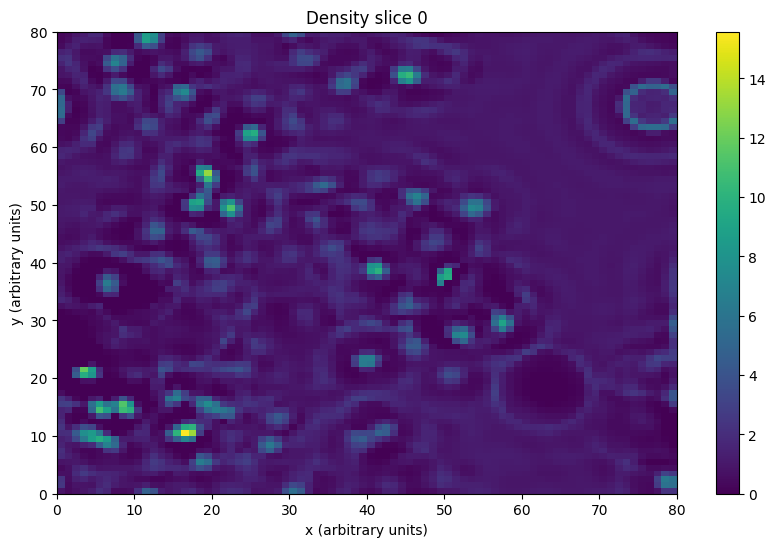

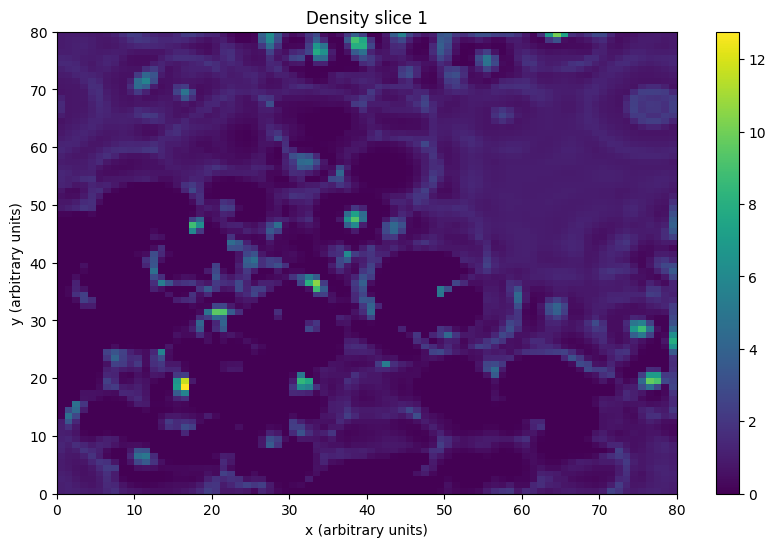

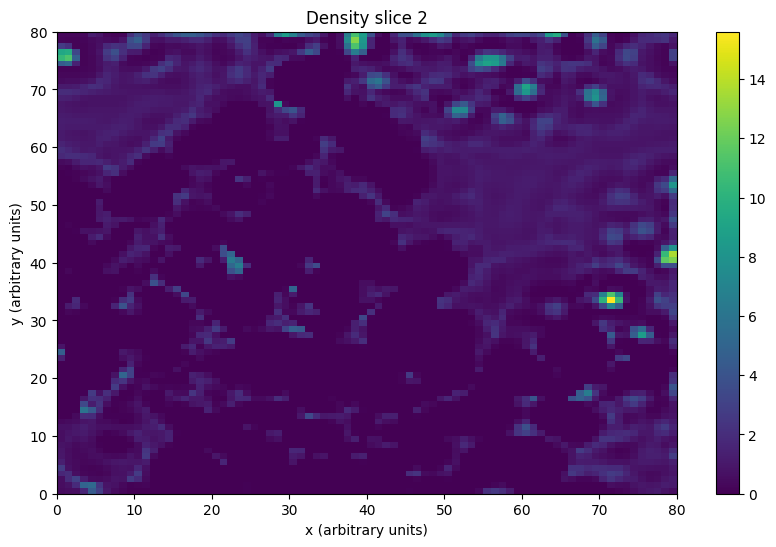

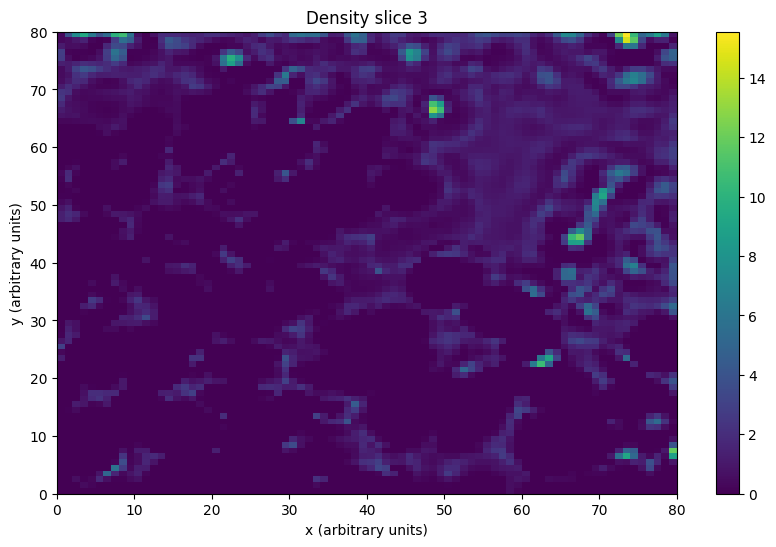

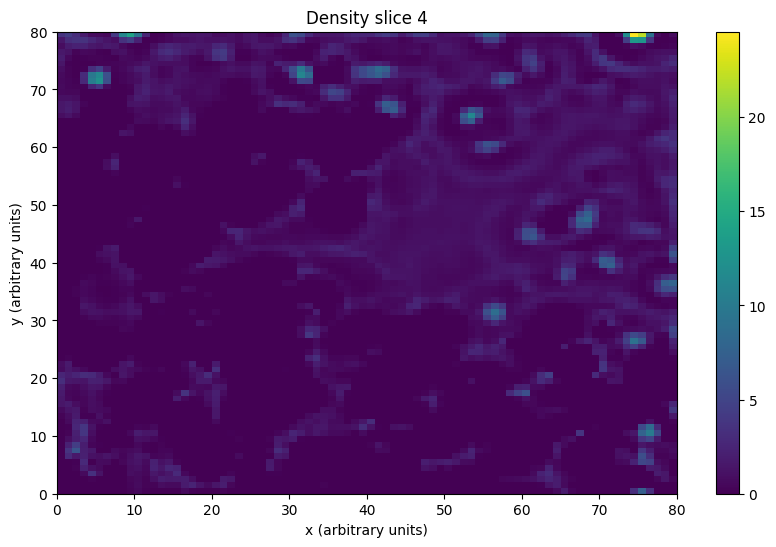

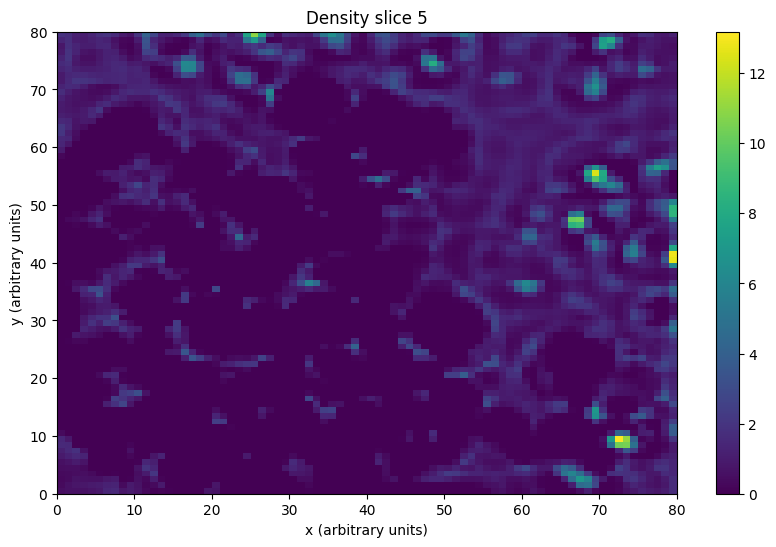

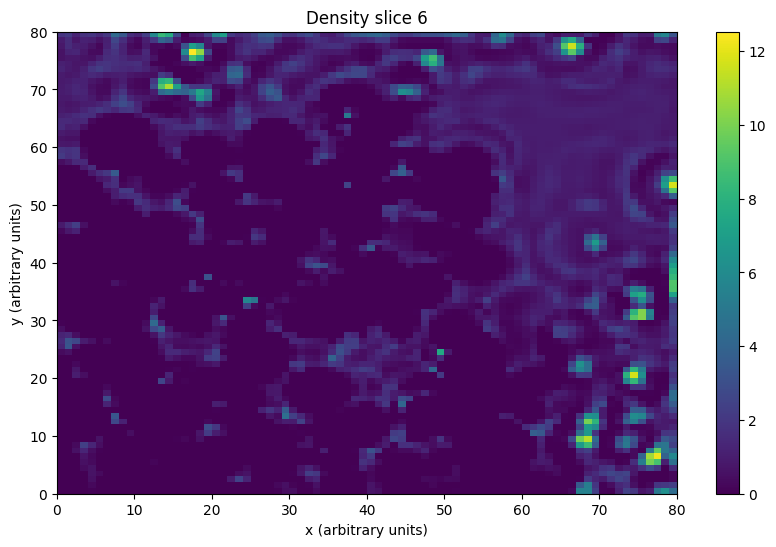

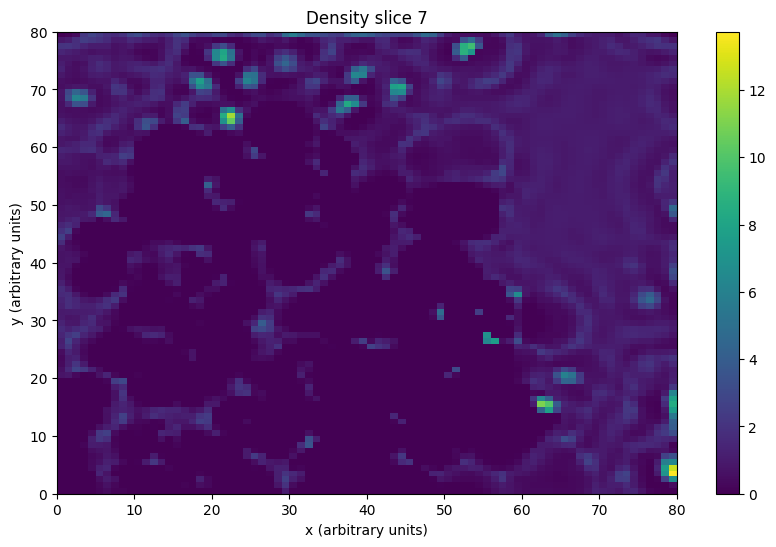

In [46]:
for k, density in enumerate(densities_bd):
    fig, ax = dsu.plot_density(
            density, title=f"Density slice {k}"
        )
plt.show()

In [47]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism_dT.O.1.dx")

In [48]:
print(find_density_origin(grid_dh))
print(find_density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[40. 40. 40.]


In [49]:
points_dh, densities_dh = density_slices_by_axis(grid, axis=np.array([1, 0, 0]), distances=np.linspace(8, 32, 4, dtype=int))

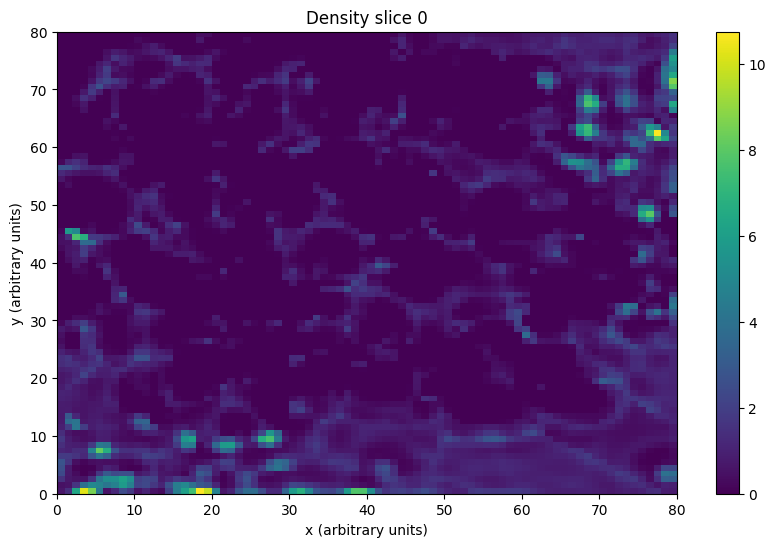

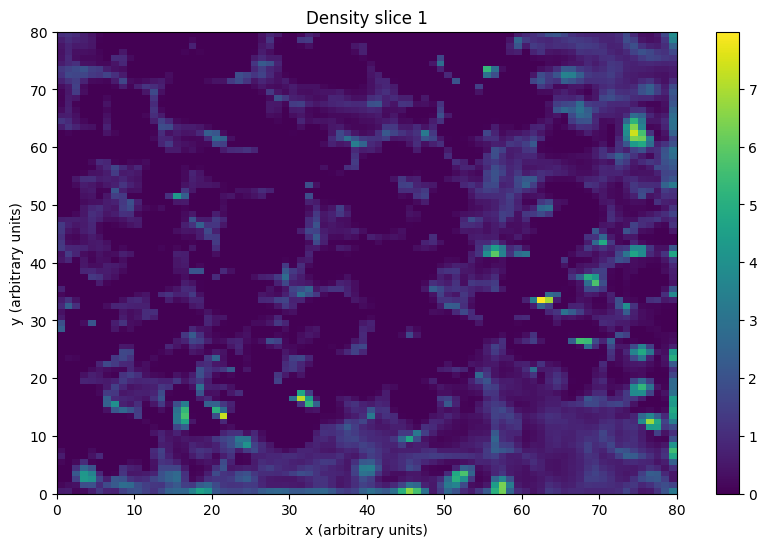

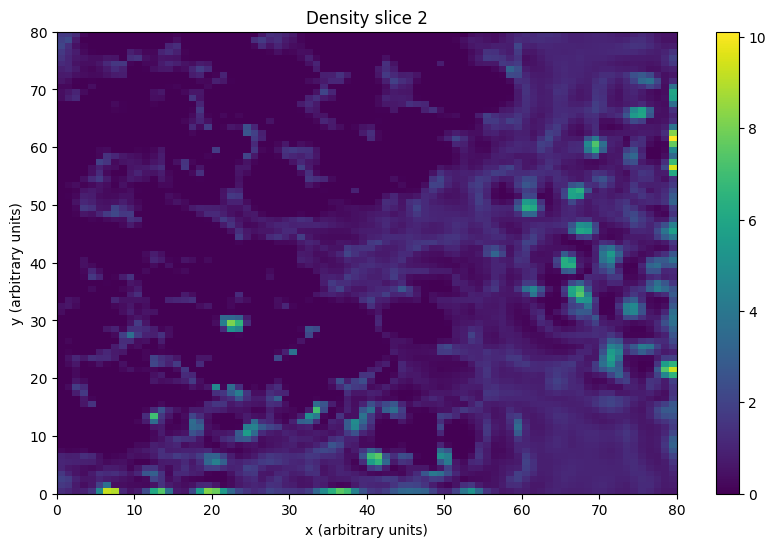

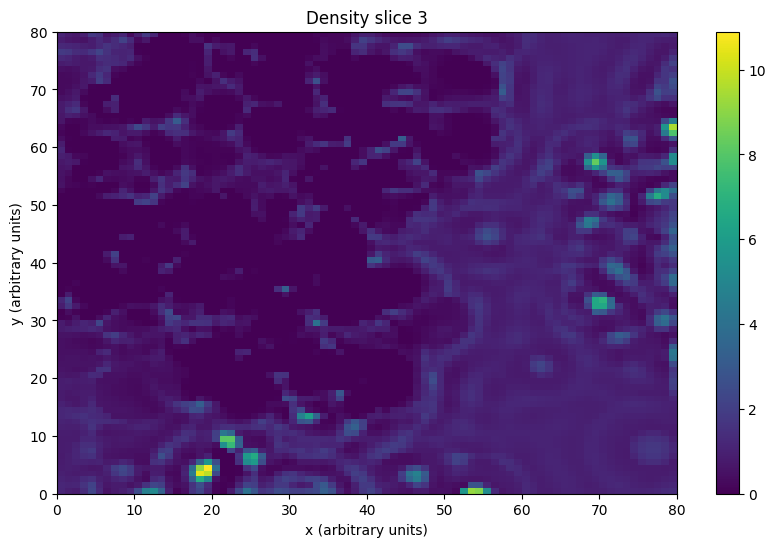

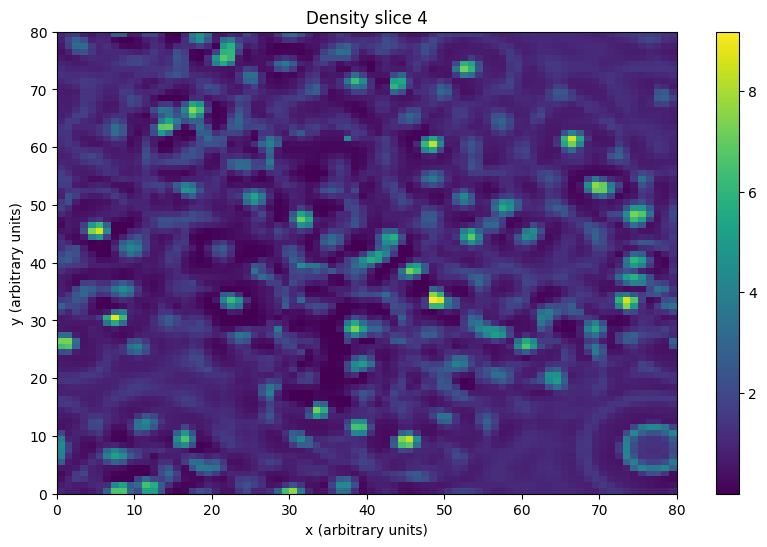

In [50]:
for k, density in enumerate(densities_dh):
    fig, ax = dsu.plot_density(
            density, title=f"Density slice {k}"
        )
plt.show()

In [51]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend
import pickle

from aquapointer import water_placement, processor


In [52]:
# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

In [53]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [54]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [55]:
test_water_postions = water_placement.find_water_positions(densities, points, executor, processor_configs)

In [56]:
print(test_water_postions)

[array([33.194, 25.341, 46.51 ]), array([38.694, 28.841, 56.51 ]), array([25.194,  8.341, 66.51 ]), array([38.694, 28.841, 66.51 ]), array([19.694, -0.659, 66.51 ]), array([22.694, 16.341, 76.51 ]), array([33.194, 25.341, 76.51 ]), array([19.694,  5.341, 76.51 ])]
